In [1]:
# I have experienced stability issues with float32.
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

import time
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad

from neurax.integrate import solve
from neurax.cell import Cell, equal_segments, linear_segments
from neurax.stimulus import Stimulus, step_current
from neurax.recording import Recording
from neurax.connection import Connection, ConnectivityBuilder
from neurax.network import Network
from neurax.mechanisms.hh_neuron import hh_neuron_gate
from neurax.mechanisms.glutamate_synapse import glutamate
from neurax.utils.swc import read_swc, plot_swc

### Set device

In [3]:
device_str = "cpu"
jax.config.update('jax_platform_name', device_str)

cpus = jax.devices("cpu")
gpus = jax.devices("gpu")

device = cpus[0] if device_str == "cpu" else gpus[0]

### Setup

In [4]:
# Number of segments per branch.
nseg_per_branch = 8

# Stimulus.
i_delay = 3.0  # ms
i_amp = 1.0  # nA
i_dur = 2.0  # ms

# Axial resisitvity.
r_a = 5_000  # ohm cm 

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms

In [5]:
time_vec = jnp.arange(0.0, t_max+dt, dt)

### Define cells

In [6]:
num_cells = 16
num_branches = 15

Below, we define the morphology. Each element of `parents` corresponds to one branch. A `-1` entry means that this branch does not have a parent. Alternatively, you could also load cells from SWC with:

```parents, lengths, endpoint_rads, start_rad = read_swc(fname, max_branch_len=300.0)```

In [7]:
parents = jnp.asarray([-1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])
assert len(parents) == num_branches

Next, we define the radius and length of each branch:

In [8]:
radiuses = [5.0] * num_branches
lengths = [10.0] * num_branches
radiuses = equal_segments(radiuses, nseg_per_branch)
lengths = equal_segments(lengths, nseg_per_branch)

Then create `num_cells` identical cells:

In [9]:
cells = [Cell(num_branches, parents, nseg_per_branch, lengths, radiuses)] * num_cells

### Define connectivity

In this case, two layers fully connected.

In [10]:
conn_builder = ConnectivityBuilder(cells)
excitatory_conns = [
    *conn_builder.fc(np.arange(0, 5), np.arange(5, 15)),
    *conn_builder.fc(np.arange(5, 15), np.arange(15, 16)),
]
conns = [excitatory_conns,]

In [11]:
network = Network(cells, conns)

### Set axial resistivity

In [12]:
network = network.set_axial_resistivities(r_a * jnp.ones((len(cells),)))

### Define stimuli and recordings

In [13]:
recs = [Recording(cell_ind, 1, 0.0) for cell_ind in range(len(cells))]
stims = [Stimulus(stim_ind, 1, 0.0, current=step_current(i_delay, i_dur, i_amp, time_vec)) for stim_ind in range(5)]

### Set initial states and parameters

In [14]:
# Initialize voltage
init_v = [
    jnp.asarray([-62.0] * num_branches*nseg_per_branch) for _ in range(num_cells)
]

# Initialize states
hh_states = [
    jnp.stack(
        [
            jnp.asarray([0.074901] * num_branches*nseg_per_branch), 
            jnp.asarray([0.4889] * num_branches*nseg_per_branch),
            jnp.asarray([0.3644787] * num_branches*nseg_per_branch),
        ]
    ) for _ in range(num_cells)
]

# Initialize parameters.
hh_params = [
    jnp.stack(
        [
            jnp.asarray([0.12] * num_branches*nseg_per_branch), 
            jnp.asarray([0.036] * num_branches*nseg_per_branch),
            jnp.asarray([0.0003] * num_branches*nseg_per_branch),
        ]
    ) for _ in range(num_cells)
]

### Define channels and synapse types

In [15]:
mem_channels = [hh_neuron_gate,]
mem_states = [hh_states,]
mem_params = [hh_params,]

syn_channels = [glutamate,]
syn_states = [jnp.zeros((len(conn))) for conn in conns]
syn_params = [jnp.asarray([2.0] * len(conn)) for conn in conns]

### Solve ODE

In [16]:
start_time = time.time()
s = solve(
    network,
    init_v,
    mem_states=mem_states,
    mem_params=mem_params,
    mem_channels=mem_channels,
    syn_states=syn_states,
    syn_params=syn_params,
    syn_channels=syn_channels,
    stimuli=stims,
    recordings=recs,
    delta_t=dt,
    solver="thomas",
    checkpoint_lengths=None,
)
print("full time", time.time() - start_time)

full time 3.446340322494507


### Visualize traces
Note that there are actually 16 traces shown. They just overlay because, in this toy example, all neurons are the same and all neurons in a layer receive the same input.

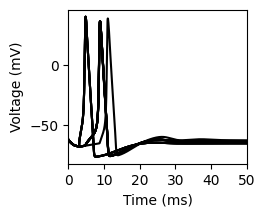

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(2.3, 2))
for i in range(len(recs)):
    _ = ax.plot(time_vec, s[i][:-1], c="k")
ax.set_xlabel("")
ax.set_xticks([])
ax.set_xticks(np.arange(0, max(time_vec)+1, 10))
ax.set_xlim([0, max(time_vec)])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Voltage (mV)")
plt.subplots_adjust(hspace=0.4)
plt.show()